#Objectif : Nombre d'arrêtés par département par mois et par niveau d'alerte

In [86]:
import os
from dotenv import load_dotenv
from pathlib import Path
import geopandas as gpd
from datetime import datetime
import pandas as pd
import json
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import requests
from matplotlib.patches import Patch
import locale
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.image as mpimg
from matplotlib.lines import Line2D

%matplotlib inline

In [4]:
def recuperation_fichiers_geojson(mois,annee,dossier_stockage):
    """
    Fonction pour récupérer les fichiers geojson d'un mois et d'une année donnés
    dans le dossier de stockage.
    """
    #récupération des fichiers geojson dans le dossier de stockage
    # Parcourir tous les fichiers du dossier
    # Chemin vers le dossier de stockage
    STORAGE = Path(dossier_stockage)

    # Dictionnaire pour stocker les DataFrames (clé = nom du fichier, valeur = DataFrame)
    dataframes = {}

    for file in STORAGE.iterdir():
        # 1. Vérifier si le fichier est un GeoJSON (extension .json ou .geojson)
        if file.suffix.lower() in [".json", ".geojson"]:
            print(f"Fichier trouvé : {file.name}")

            # 2. Récupérer les métadonnées du fichier pour la date de création
            stat = file.stat()

            # 3. recupération de la date contenu dans le nom du fichier
            date_telechargmement_str = file.stem.split('_')[-1]  # Extraction de la partie date
            date_telechargmement = datetime.strptime(date_telechargmement_str, "%Y-%m-%d").date() # Conversion en objet datetime
            print(f"Date extraite du nom de fichier : {date_telechargmement}")
            annee_telechargement = date_telechargmement.year
            #print(f"Année de téléchargement : {annee_telechargement}")
            mois_telechargement = date_telechargmement.month
            #print(f"Mois de téléchargement : {mois_telechargement}")
            jour_telechargement = date_telechargmement.day
            #print(f"Jour de téléchargement : {jour_telechargement}")
            
            # 4. Filtrer par mois et année
            if annee_telechargement != annee or mois_telechargement != mois:
                print(f"Ignoré : le fichier {file.name} ne correspond pas au mois {mois} et à l'année {annee}.\n")
                continue

            # 5. Lire le fichier GeoJSON avec GeoPandas
            gdf = gpd.read_file(file)
            # Ajouter une colonne avec la date de téléchargement
            gdf["date téléchargement"] = date_telechargmement
            #display(gdf.head())
            # Convertir colonnes str en dictionnaire : 'arreteRestriction' et 'departement'
            colonnes_dict = ['arreteRestriction', 'departement']
            for col in colonnes_dict:
                if col not in gdf.columns:
                    print(f"Attention : la colonne '{col}' est absente dans le fichier {file.name}.")
                else:
                    gdf[col] = gdf[col].apply(
                lambda x: json.loads(x.replace(r'\/', '/')) if isinstance(x, str) else x
            )
            # normaliser les colonnes de type dictionnaire en colonnes plates       
            arrete_df = pd.json_normalize(gdf['arreteRestriction']).add_prefix('arrete_')
            #display(arrete_df.head())
            departements_df = pd.json_normalize(gdf['departement']).add_prefix('departement_')
            #display(departements_df.head())
            gdf = pd.concat([gdf, arrete_df, departements_df], axis=1).drop(columns=['arreteRestriction', 'departement'])
            gdf.to_csv(f"export_data/{file.stem}.csv", index=False, encoding='utf-8-sig')
            

            # 5. Afficher les infos : nom, date de création, nombre de géométries
            print(f"--- Fichier: {file.name} ---")
            # print(f"Date de création : {date_creation}")
            # print(f"Date de modification : {date_modification}")
            print(f"Nombre de géométries : {len(gdf)}\n")

            

            # Stocker le DataFrame dans le dictionnaire avec le nom du fichier comme clé
            dataframes[file.stem] = gdf  # file.stem = nom du fichier sans extension

            # Afficher un résumé
            print(f"DataFrame '{file.stem}' créé avec {len(gdf)} géométries.\n")
    return dataframes


In [5]:
def compilation_restrictions_mensuelles(dfs):
    arretes_mois = pd.concat(dfs.values(), ignore_index=True)
    # Filtrage des types SUP et SOU
    arretes_mois_SUP_SOU = arretes_mois[arretes_mois['type'].isin(['SUP', 'SOU'])]
    

    # Sélection des colonnes d'intérêt et suppression des doublons
    colonnes_select = ['departement_code','departement_nom','arrete_id','niveauGravite']
    df_mois_SUP_SOU = arretes_mois_SUP_SOU[colonnes_select]
    df_mois_SUP_SOU = df_mois_SUP_SOU.drop_duplicates()
    
    # Création du tableau croisé dynamique
    resultat = df_mois_SUP_SOU.pivot_table(
        index=['departement_code', 'departement_nom'],
        columns='niveauGravite',
        values='arrete_id', 
        aggfunc='count',    # ou 'size' si on veut les nan
        fill_value=0        # Remplace les NaN par 0
    )
    
    #print("Colonnes avant réorganisation :", resultat.columns.tolist())
    #convertir les niveaux de gravité en integral
    colonnes_a_convertir = ['alerte', 'alerte_renforcee', 'crise', 'vigilance']
    for col in colonnes_a_convertir:
        resultat[col] = resultat[col].apply(lambda x: int(x))

    return resultat


In [6]:
def recuperation_departements():
    # URL du service WFS de l'IGN pour les départements
    url = "https://data.geopf.fr/wfs/ows?SERVICE=WFS&VERSION=2.0.0&REQUEST=GetFeature&TYPENAMES=LIMITES_ADMINISTRATIVES_EXPRESS.LATEST:departement&OUTPUTFORMAT=application/json"

    # Récupération des données
    response = requests.get(url)
    departements = response.json()

    # Sauvegarder dans un fichier GeoJSON
    with open('geojson/departements.geojson', 'w', encoding='utf-8') as f:
        f.write(response.text)

    print("Fichier GeoJSON enregistré sous 'departements.geojson'.")
    departements_gdf = gpd.read_file('geojson/departements.geojson')
    return departements_gdf

In [7]:
#fusion des données des arrêtés avec les départements
def fusionner_donnees_departements(bilan_mois, departements_gdf):
    merged_gdf = departements_gdf.merge(bilan_mois, left_on='code_insee', right_on='departement_code' , how='left')
    colonnes_a_convertir = ['alerte', 'alerte_renforcee', 'crise', 'vigilance']
    merged_gdf[colonnes_a_convertir] = merged_gdf[colonnes_a_convertir].apply(pd.to_numeric, errors='coerce').astype('Int64')
    return merged_gdf

In [8]:
def filtre_metropole(merged_gdf):
    return merged_gdf[merged_gdf['code_insee'].str.len() == 2]


In [98]:
def create_bar_chart_map(data, mois, annee):

    mois_name = datetime(annee, mois, 1).strftime('%B')

    fig, ax = plt.subplots(figsize=(20, 20))

    # Définir une palette de couleurs pour les départements avec données
    colors_dept = ['#e6f3ff' if pd.isna(row['vigilance']) and pd.isna(row['alerte']) and pd.isna(row['alerte_renforcee']) and pd.isna(row['crise'])
                else '#b3d9ff' for idx, row in data.iterrows()]

    # Valeur maximale globale pour normalisation
    max_value = data[['vigilance', 'alerte', 'alerte_renforcee', 'crise']].max().max()

    # Tracer la carte des départements avec couleur de fond
    data.plot(ax=ax, color=colors_dept, edgecolor='black', linewidth=0.5)

    # Obtenir les limites de la carte et les ajuster
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x_range_original = xlim[1] - xlim[0]
    y_range_original = ylim[1] - ylim[0]
    
    # Ajouter une marge pour éviter que la carte soit coupée (5% de chaque côté)
    margin = 0.05
    ax.set_xlim(xlim[0] - margin * x_range_original, xlim[1] + margin * x_range_original)
    ax.set_ylim(ylim[0] - margin * y_range_original, ylim[1] + margin * y_range_original)
    
    # Recalculer les ranges après ajustement
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]

    # Pour chaque département avec données
    for idx, row in data.iterrows():
        if pd.isna(row['vigilance']) and pd.isna(row['alerte']) and pd.isna(row['alerte_renforcee']) and pd.isna(row['crise']):
            continue

        values = [row['vigilance'], row['alerte'], row['alerte_renforcee'], row['crise']]

        # Normaliser les valeurs (hauteur modérée)
        normalized_values = [v / max_value * 0.03 * y_range for v in values]

        center = row.geometry.centroid
        x_center, y_center = center.x, center.y

        # Positions des barres (décalage modéré)
        x_positions = [
            x_center - 0.01 * x_range,
            x_center - 0.004 * x_range,
            x_center + 0.004 * x_range,
            x_center + 0.01 * x_range
        ]

        # Position de base des barres
        bottom = y_center - 0.007 * y_range

        # Tracer l'axe horizontal (longueur modérée)
        ax.plot([x_center - 0.015 * x_range, x_center + 0.015 * x_range], [bottom, bottom],
                color='black', linewidth=0.4)

        # Tracer l'axe vertical (hauteur modérée)
        ax.plot([x_center - 0.015 * x_range, x_center - 0.015 * x_range],
                [bottom, bottom + 0.03 * y_range], color='black', linewidth=0.4)

        # Ajouter des graduations sur l'axe horizontal
        for i, x in enumerate(x_positions):
            ax.plot([x, x], [bottom - 0.0015 * y_range, bottom], color='black', linewidth=0.4)

        # Ajouter des graduations sur l'axe vertical
        for y_tick in [0, 0.5 * max_value, max_value]:
            y_tick = int(y_tick)
            y_tick_pos = bottom + (y_tick / max_value) * 0.03 * y_range
            ax.plot([x_center - 0.015 * x_range - 0.0015 * x_range, x_center - 0.015 * x_range],
                    [y_tick_pos, y_tick_pos], color='black', linewidth=0.4)
            ax.text(x_center - 0.015 * x_range - 0.004 * y_range, y_tick_pos,
                    f"{y_tick}", ha='right', va='center', fontsize=4)

        # Tracer les barres (largeur modérée)
        for i, (value, color) in enumerate(zip(normalized_values, ['#99ff99', '#66b3ff', '#ff9999', '#ff6666'])):
            ax.bar(x=x_positions[i], height=value, width=0.0045 * x_range, bottom=bottom,
                color=color, edgecolor='black', linewidth=0.3)

    # Légende et titre
    legend_elements = [
    Patch(facecolor='#99ff99', edgecolor='black', label='Vigilance'),
    Patch(facecolor='#66b3ff', edgecolor='black', label='Alerte'),
    Patch(facecolor='#ff9999', edgecolor='black', label='Alerte Renforcée'),
    Patch(facecolor='#ff6666', edgecolor='black', label='Crise')
    ]
    
    # Bloc de texte pour les sources
    fig.text(0.1, 0.15, 'Sources : VigiEau (https://www.data.gouv.fr/api/1/datasets/r/e403a885-5eaf-411d-a03e-751a9c22930d)', fontsize=12)

    # Souligner "Sources" avec une ligne continue
    line = Line2D(
        [0.1, 0.14],
        [0.148, 0.148],
        color='black',
        linewidth=1,
        transform=fig.transFigure
    )
    fig.add_artist(line)

    #logos
    logo_oieau = mpimg.imread('logos/logo_oieau.jpeg')
    
    imagebox_oieau = OffsetImage(logo_oieau, zoom=0.1)
    
    ab_oieau = AnnotationBbox(
        imagebox_oieau,
        (0.9, 0.01),
        frameon=False,
        xycoords='axes fraction'
    )
 
    ax.add_artist(ab_oieau)

    # Ajouter la légende
    ax.legend(handles=legend_elements, fontsize=14, loc='right')
    plt.title(f"Niveaux de restriction d'eau par département - France métropolitaine \n Eaux souterraines et Eaux superficielles \n {mois_name} {annee}", fontsize=28)
    plt.axis('off')
    
    # Sauvegarder avec un padding pour éviter les coupures
    plt.savefig(f'carte_departements_barres_{mois}_{annee}.png', dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()
    plt.close()

In [117]:
def create_gradient_map(data, mois, annee):
    mois_name = datetime(annee, mois, 1).strftime('%B')
    
    fig, ax = plt.subplots(figsize=(20, 20))
    
    # Couleurs pour chaque niveau
    colors = {
        'vigilance': '#99ff99',
        'alerte': '#66b3ff',
        'alerte_renforcee': '#ff9999',
        'crise': '#ff6666'
    }
    
    # D'abord tracer tous les départements en blanc/gris clair
    data.plot(ax=ax, color='#f0f0f0', edgecolor='black', linewidth=0.5)

    # Obtenir les limites de la carte et les ajuster
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    x_range_original = xlim[1] - xlim[0]
    y_range_original = ylim[1] - ylim[0]
    
    # Ajouter une marge pour éviter que la carte soit coupée (5% de chaque côté)
    margin = 0.05
    ax.set_xlim(xlim[0] - margin * x_range_original, xlim[1] + margin * x_range_original)
    ax.set_ylim(ylim[0] - margin * y_range_original, ylim[1] + margin * y_range_original)
    
    # Recalculer les ranges après ajustement
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_range = xlim[1] - xlim[0]
    y_range = ylim[1] - ylim[0]
    
    # Pour chaque département avec données
    for idx, row in data.iterrows():
        values = {
            'vigilance': row['vigilance'],
            'alerte': row['alerte'],
            'alerte_renforcee': row['alerte_renforcee'],
            'crise': row['crise']
        }
        
        # Vérifier s'il y a des données
        if all(pd.isna(v) for v in values.values()):
            continue
        
        # Remplacer NaN par 0
        values = {k: (v if not pd.isna(v) else 0) for k, v in values.items()}
        total = sum(values.values())
        
        if total == 0:
            continue
        
        # Obtenir la géométrie du département
        geom = row.geometry
        bounds = geom.bounds  # (minx, miny, maxx, maxy)
        
        # Créer des bandes horizontales pour chaque niveau
        current_y = bounds[1]  # Partir du bas
        height = bounds[3] - bounds[1]
        
        # Ordre d'empilement (du bas vers le haut)
        ordre = ['vigilance', 'alerte', 'alerte_renforcee', 'crise']
        
        for niveau in ordre:
            if values[niveau] > 0:
                proportion = values[niveau] / total
                band_height = height * proportion
                
                # Créer un rectangle pour cette bande
                from shapely.geometry import box
                band = box(bounds[0], current_y, bounds[2], current_y + band_height)
                
                # Intersection avec la géométrie du département
                clipped = geom.intersection(band)
                
                # Tracer cette portion
                if not clipped.is_empty:
                    gpd.GeoSeries([clipped]).plot(
                        ax=ax, 
                        color=colors[niveau], 
                        edgecolor='none'
                    )
                
                current_y += band_height
    
    # Retracer les contours des départements par-dessus
    data.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
    
    # Légende
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#99ff99', edgecolor='black', label='Vigilance'),
        Patch(facecolor='#66b3ff', edgecolor='black', label='Alerte'),
        Patch(facecolor='#ff9999', edgecolor='black', label='Alerte Renforcée'),
        Patch(facecolor='#ff6666', edgecolor='black', label='Crise')
    ]

    ax.legend(handles=legend_elements, fontsize=14, loc='right')

    # Bloc de texte pour les sources
    fig.text(0.03, 0.05, 'Sources : VigiEau (https://www.data.gouv.fr/api/1/datasets/r/e403a885-5eaf-411d-a03e-751a9c22930d)', fontsize=12)

    # Souligner "Sources" avec une ligne continue
    line = Line2D(
        [0.03, 0.06],
        [0.048, 0.048],
        color='black',
        linewidth=1,
        transform=fig.transFigure
    )
    fig.add_artist(line)

    #logos
    logo_oieau = mpimg.imread('logos/logo_oieau.jpeg')
    
    imagebox_oieau = OffsetImage(logo_oieau, zoom=0.1)
    
    ab_oieau = AnnotationBbox(
        imagebox_oieau,
        (0.9, 0.03),
        frameon=False,
        xycoords='axes fraction'
    )
 
    ax.add_artist(ab_oieau)
    
    plt.title(f"Niveaux de restriction d'eau par département - France métropolitaine \n Eaux souterraines et Eaux superficielles \n {mois_name} {annee}", fontsize=28)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'carte_departements_gradient_{mois}_{annee}.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

## Dossier de stockage : à modifier si utilisation du réseau

In [11]:
#dossier de stockage des fichiers geojson
# Chargement des variables d'environnement
load_dotenv()
STORAGE_DIR = os.getenv("STORAGE_DIR")

# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

'fr_FR.UTF-8'

In [12]:
dfs = recuperation_fichiers_geojson(mois=1, annee=2026, dossier_stockage=STORAGE_DIR)


Fichier trouvé : fichier_geojson_2026-01-14.json
Date extraite du nom de fichier : 2026-01-14
--- Fichier: fichier_geojson_2026-01-14.json ---
Nombre de géométries : 110

DataFrame 'fichier_geojson_2026-01-14' créé avec 110 géométries.

Fichier trouvé : fichier_geojson_2026-01-15.json
Date extraite du nom de fichier : 2026-01-15
--- Fichier: fichier_geojson_2026-01-15.json ---
Nombre de géométries : 111

DataFrame 'fichier_geojson_2026-01-15' créé avec 111 géométries.

Fichier trouvé : fichier_geojson_2026-02-15.json
Date extraite du nom de fichier : 2026-02-15
Ignoré : le fichier fichier_geojson_2026-02-15.json ne correspond pas au mois 1 et à l'année 2026.



In [13]:
# for nom_fichier, df in dfs.items():
#     print(f"DataFrame pour le fichier '{nom_fichier}':")
#     display(df.head())

In [14]:
bilan_mois = compilation_restrictions_mensuelles(dfs)
bilan_mois

,niveauGravite,alerte,alerte_renforcee,crise,vigilance
departement_code,departement_nom,,,,
01,Ain,0,1,0,0
11,Aude,1,0,1,1
2A,Corse-du-Sud,0,2,0,0
2B,Haute-Corse,0,0,0,1
34,Hérault,1,1,1,1
66,Pyrénées-Orientales,1,1,1,0
974,La Réunion,1,0,0,0


In [15]:
departements_gdf = recuperation_departements()

Fichier GeoJSON enregistré sous 'departements.geojson'.


In [16]:
merged_gdf = fusionner_donnees_departements(bilan_mois, departements_gdf)

In [17]:
metropole_gdf = filtre_metropole(merged_gdf)

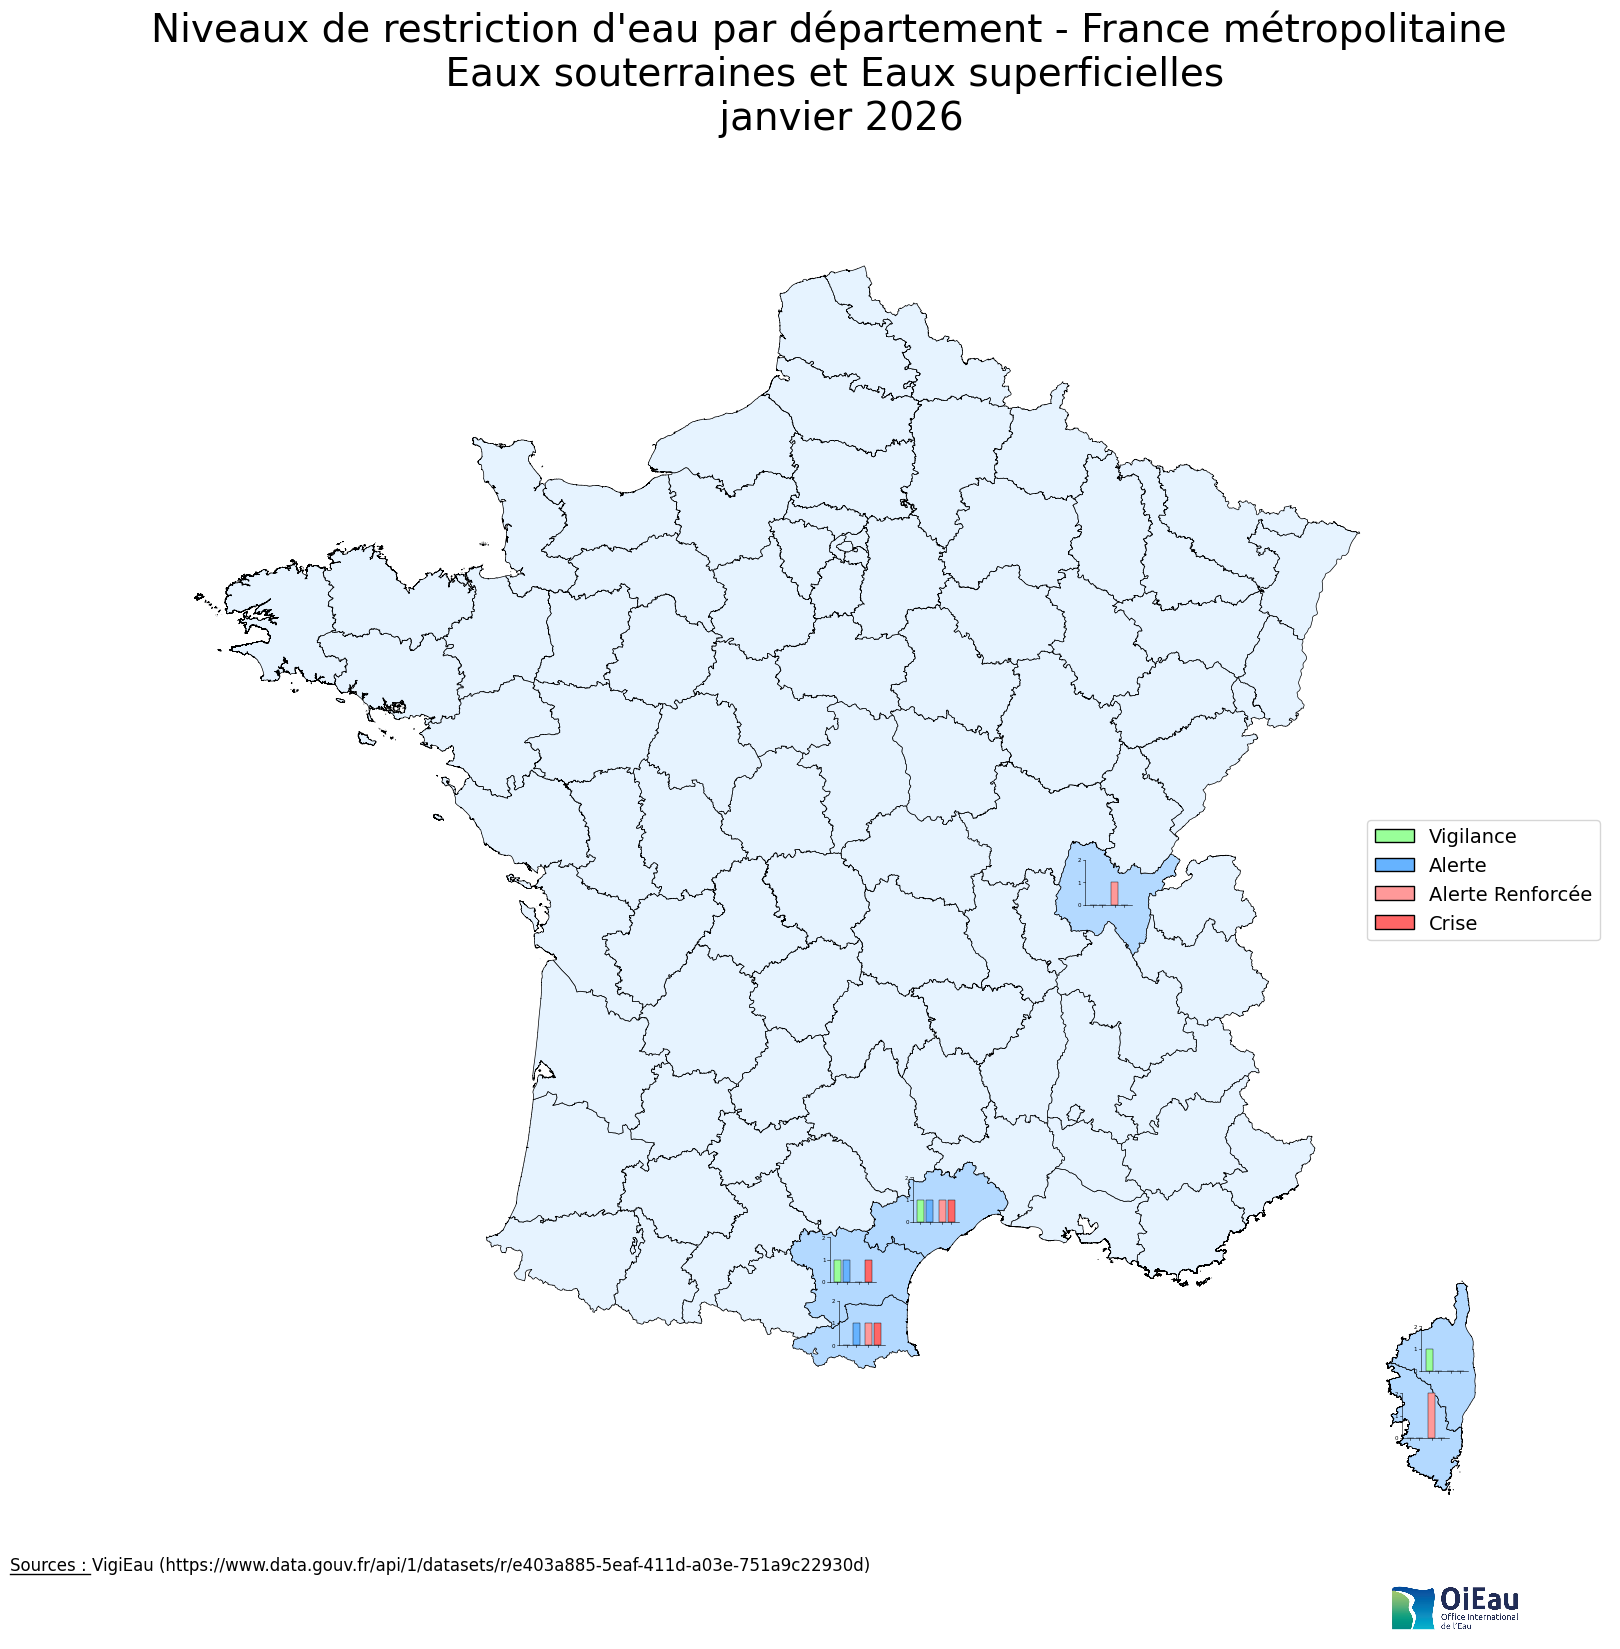

In [100]:
create_bar_chart_map(metropole_gdf, mois=1, annee=2026)

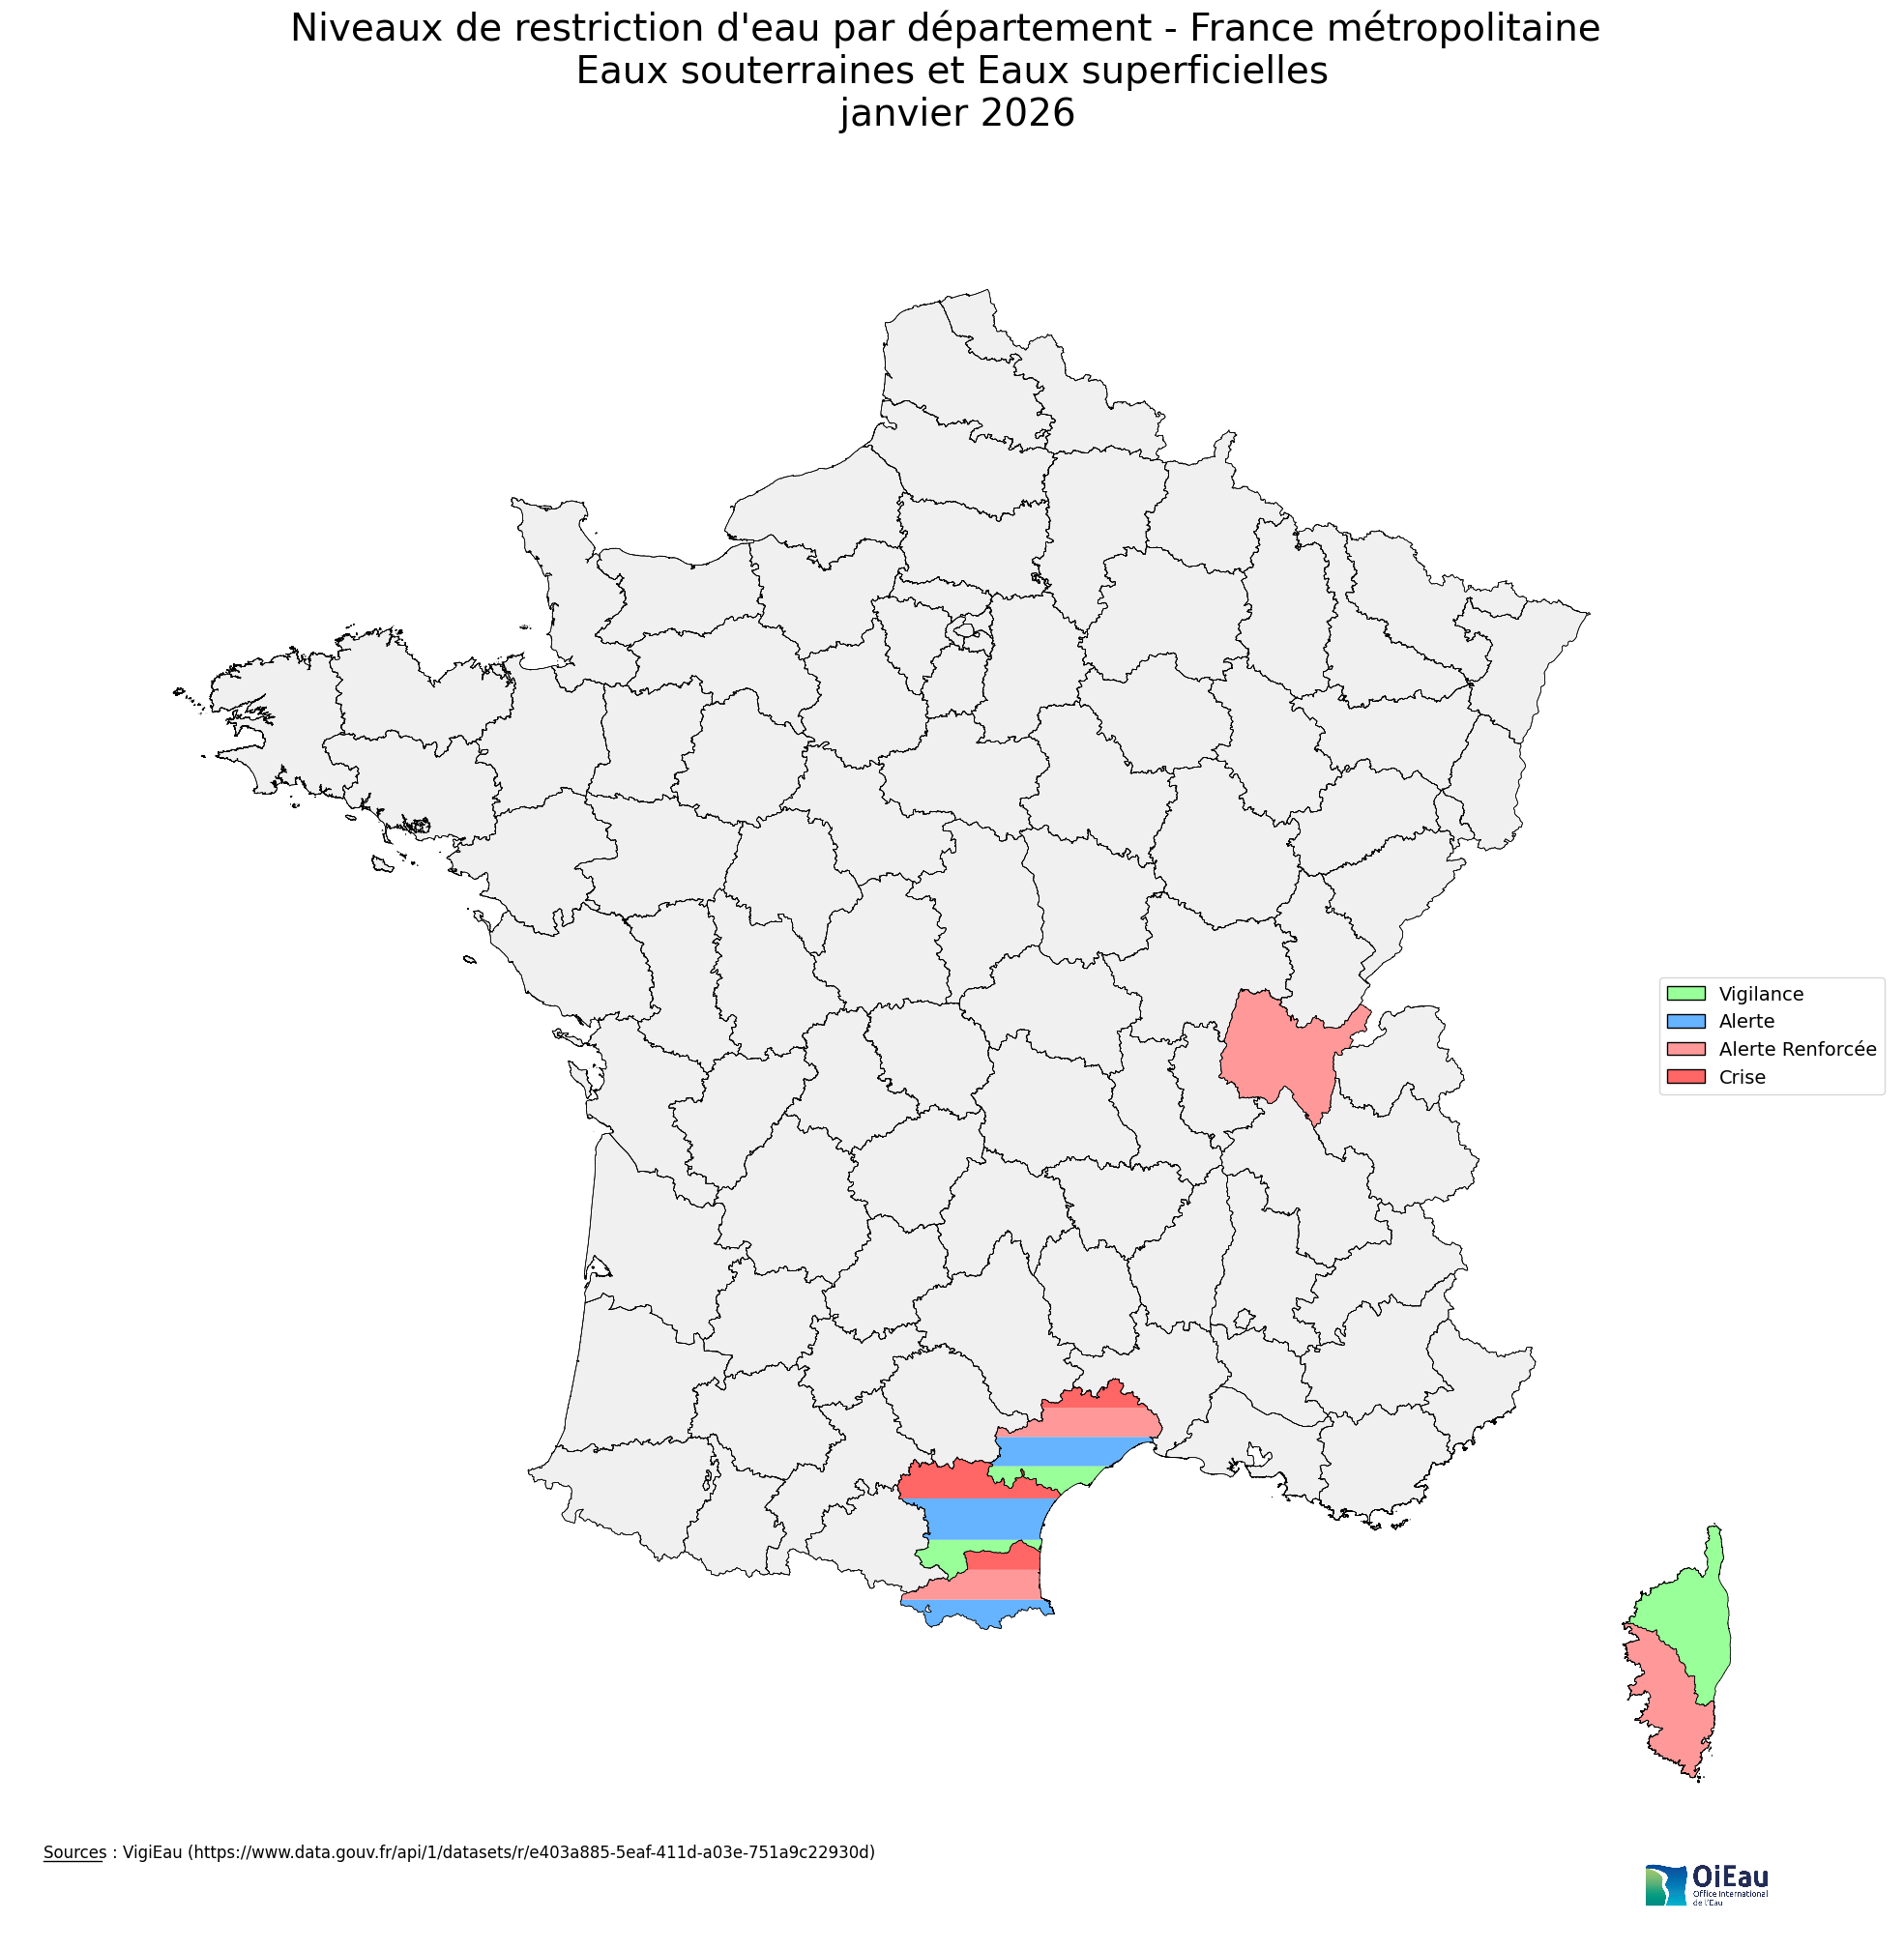

In [118]:
create_gradient_map(metropole_gdf, mois=1, annee=2026)

In [120]:
def global_carte(mois, annee, dossier_stockage):
    dfs = recuperation_fichiers_geojson(mois=mois, annee=annee, dossier_stockage=dossier_stockage)
    bilan_mois = compilation_restrictions_mensuelles(dfs)
    departements_gdf = recuperation_departements()
    merged_gdf = fusionner_donnees_departements(bilan_mois, departements_gdf)
    metropole_gdf = filtre_metropole(merged_gdf)
    create_bar_chart_map(metropole_gdf, mois=mois, annee=annee)
    create_gradient_map(metropole_gdf, mois=mois, annee=annee)

Fichier trouvé : fichier_geojson_2026-01-14.json
Date extraite du nom de fichier : 2026-01-14
--- Fichier: fichier_geojson_2026-01-14.json ---
Nombre de géométries : 110

DataFrame 'fichier_geojson_2026-01-14' créé avec 110 géométries.

Fichier trouvé : fichier_geojson_2026-01-15.json
Date extraite du nom de fichier : 2026-01-15
--- Fichier: fichier_geojson_2026-01-15.json ---
Nombre de géométries : 111

DataFrame 'fichier_geojson_2026-01-15' créé avec 111 géométries.

Fichier trouvé : fichier_geojson_2026-02-15.json
Date extraite du nom de fichier : 2026-02-15
Ignoré : le fichier fichier_geojson_2026-02-15.json ne correspond pas au mois 1 et à l'année 2026.

Fichier GeoJSON enregistré sous 'departements.geojson'.


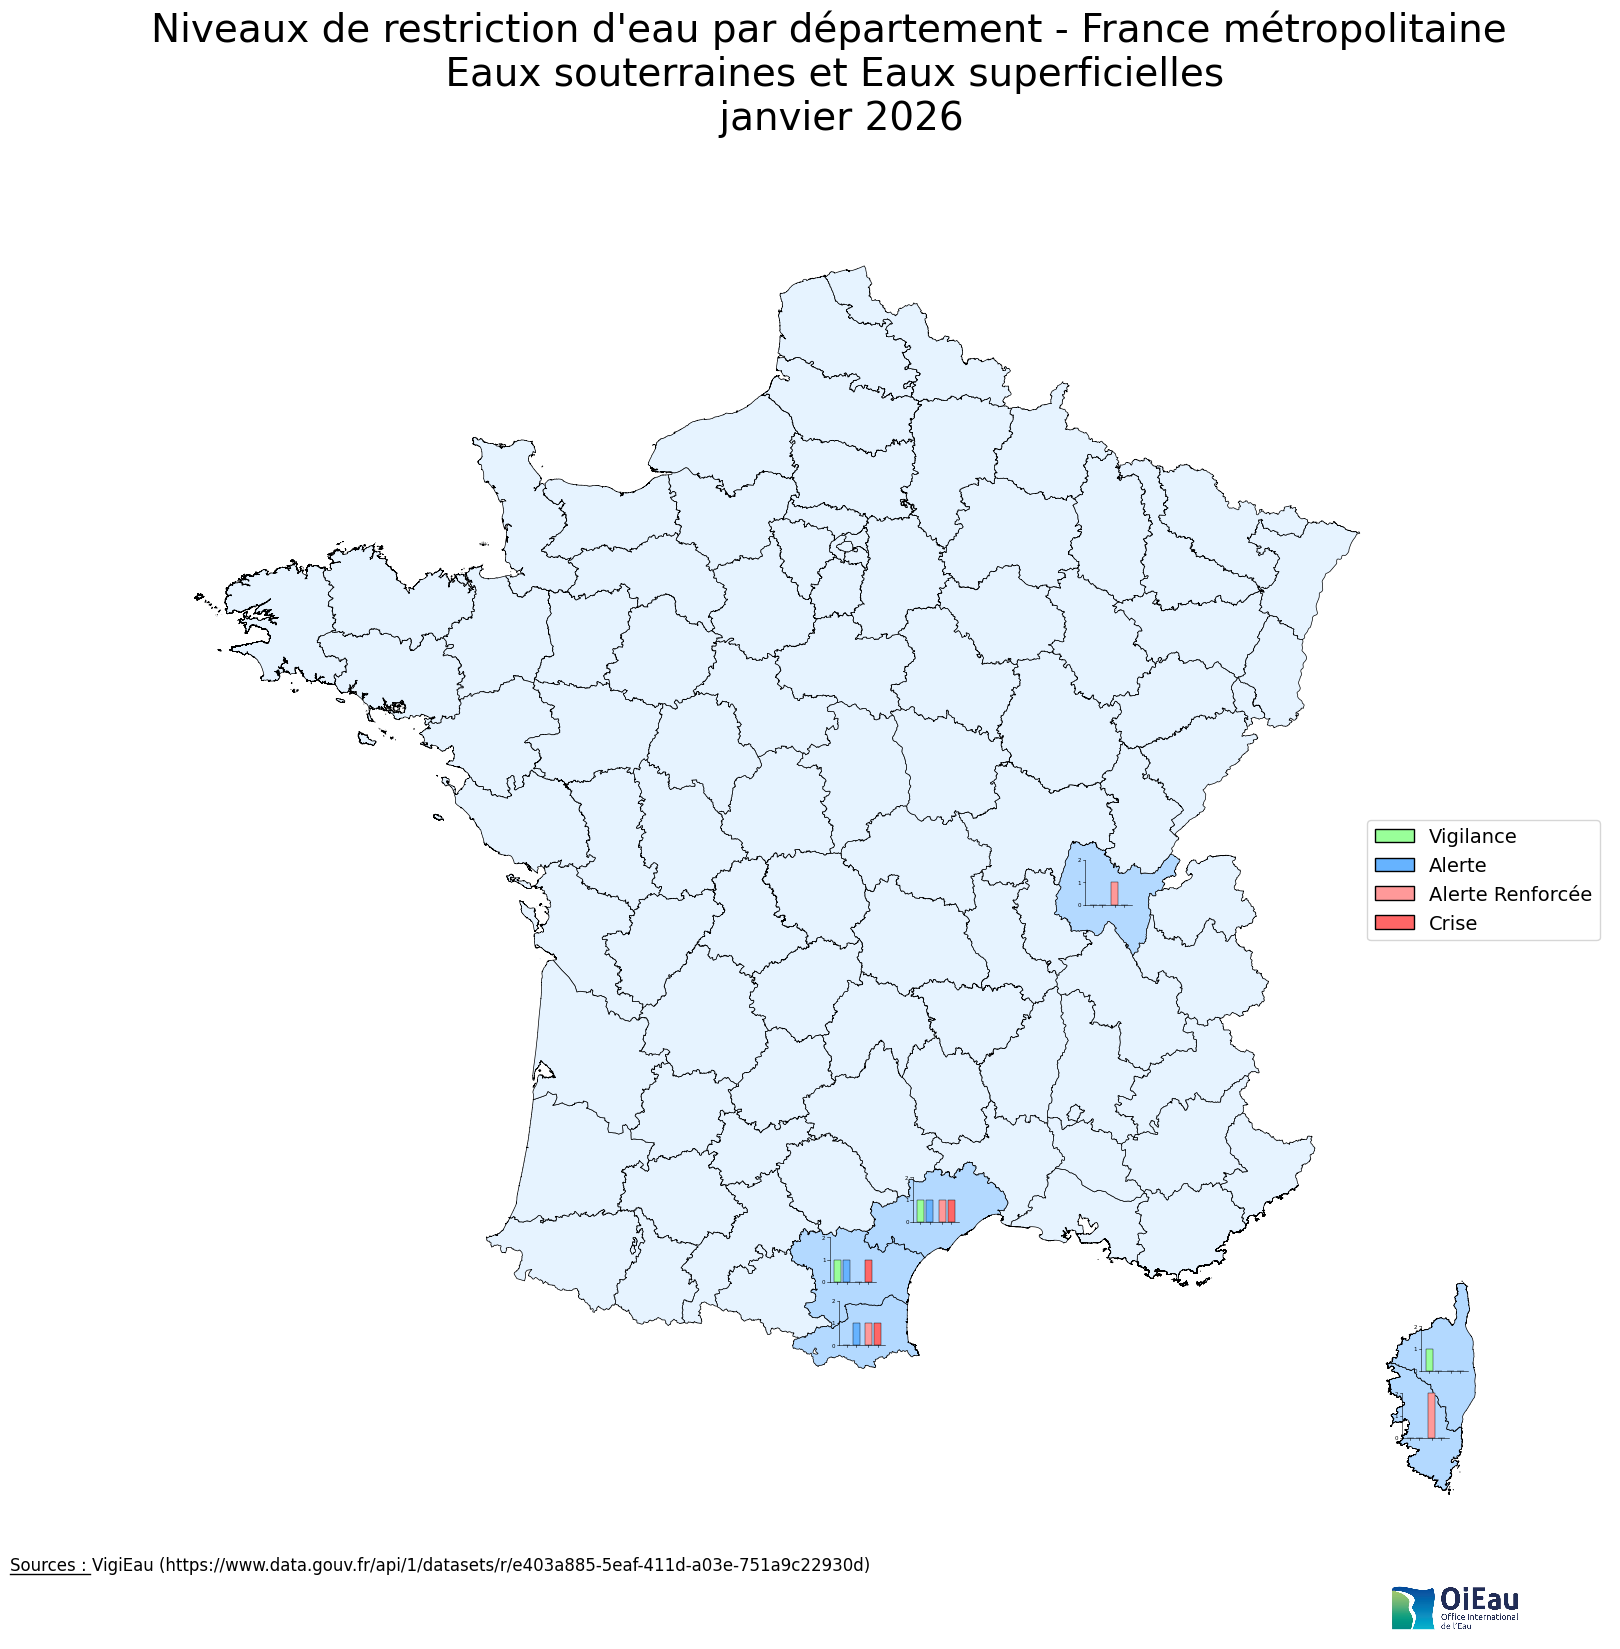

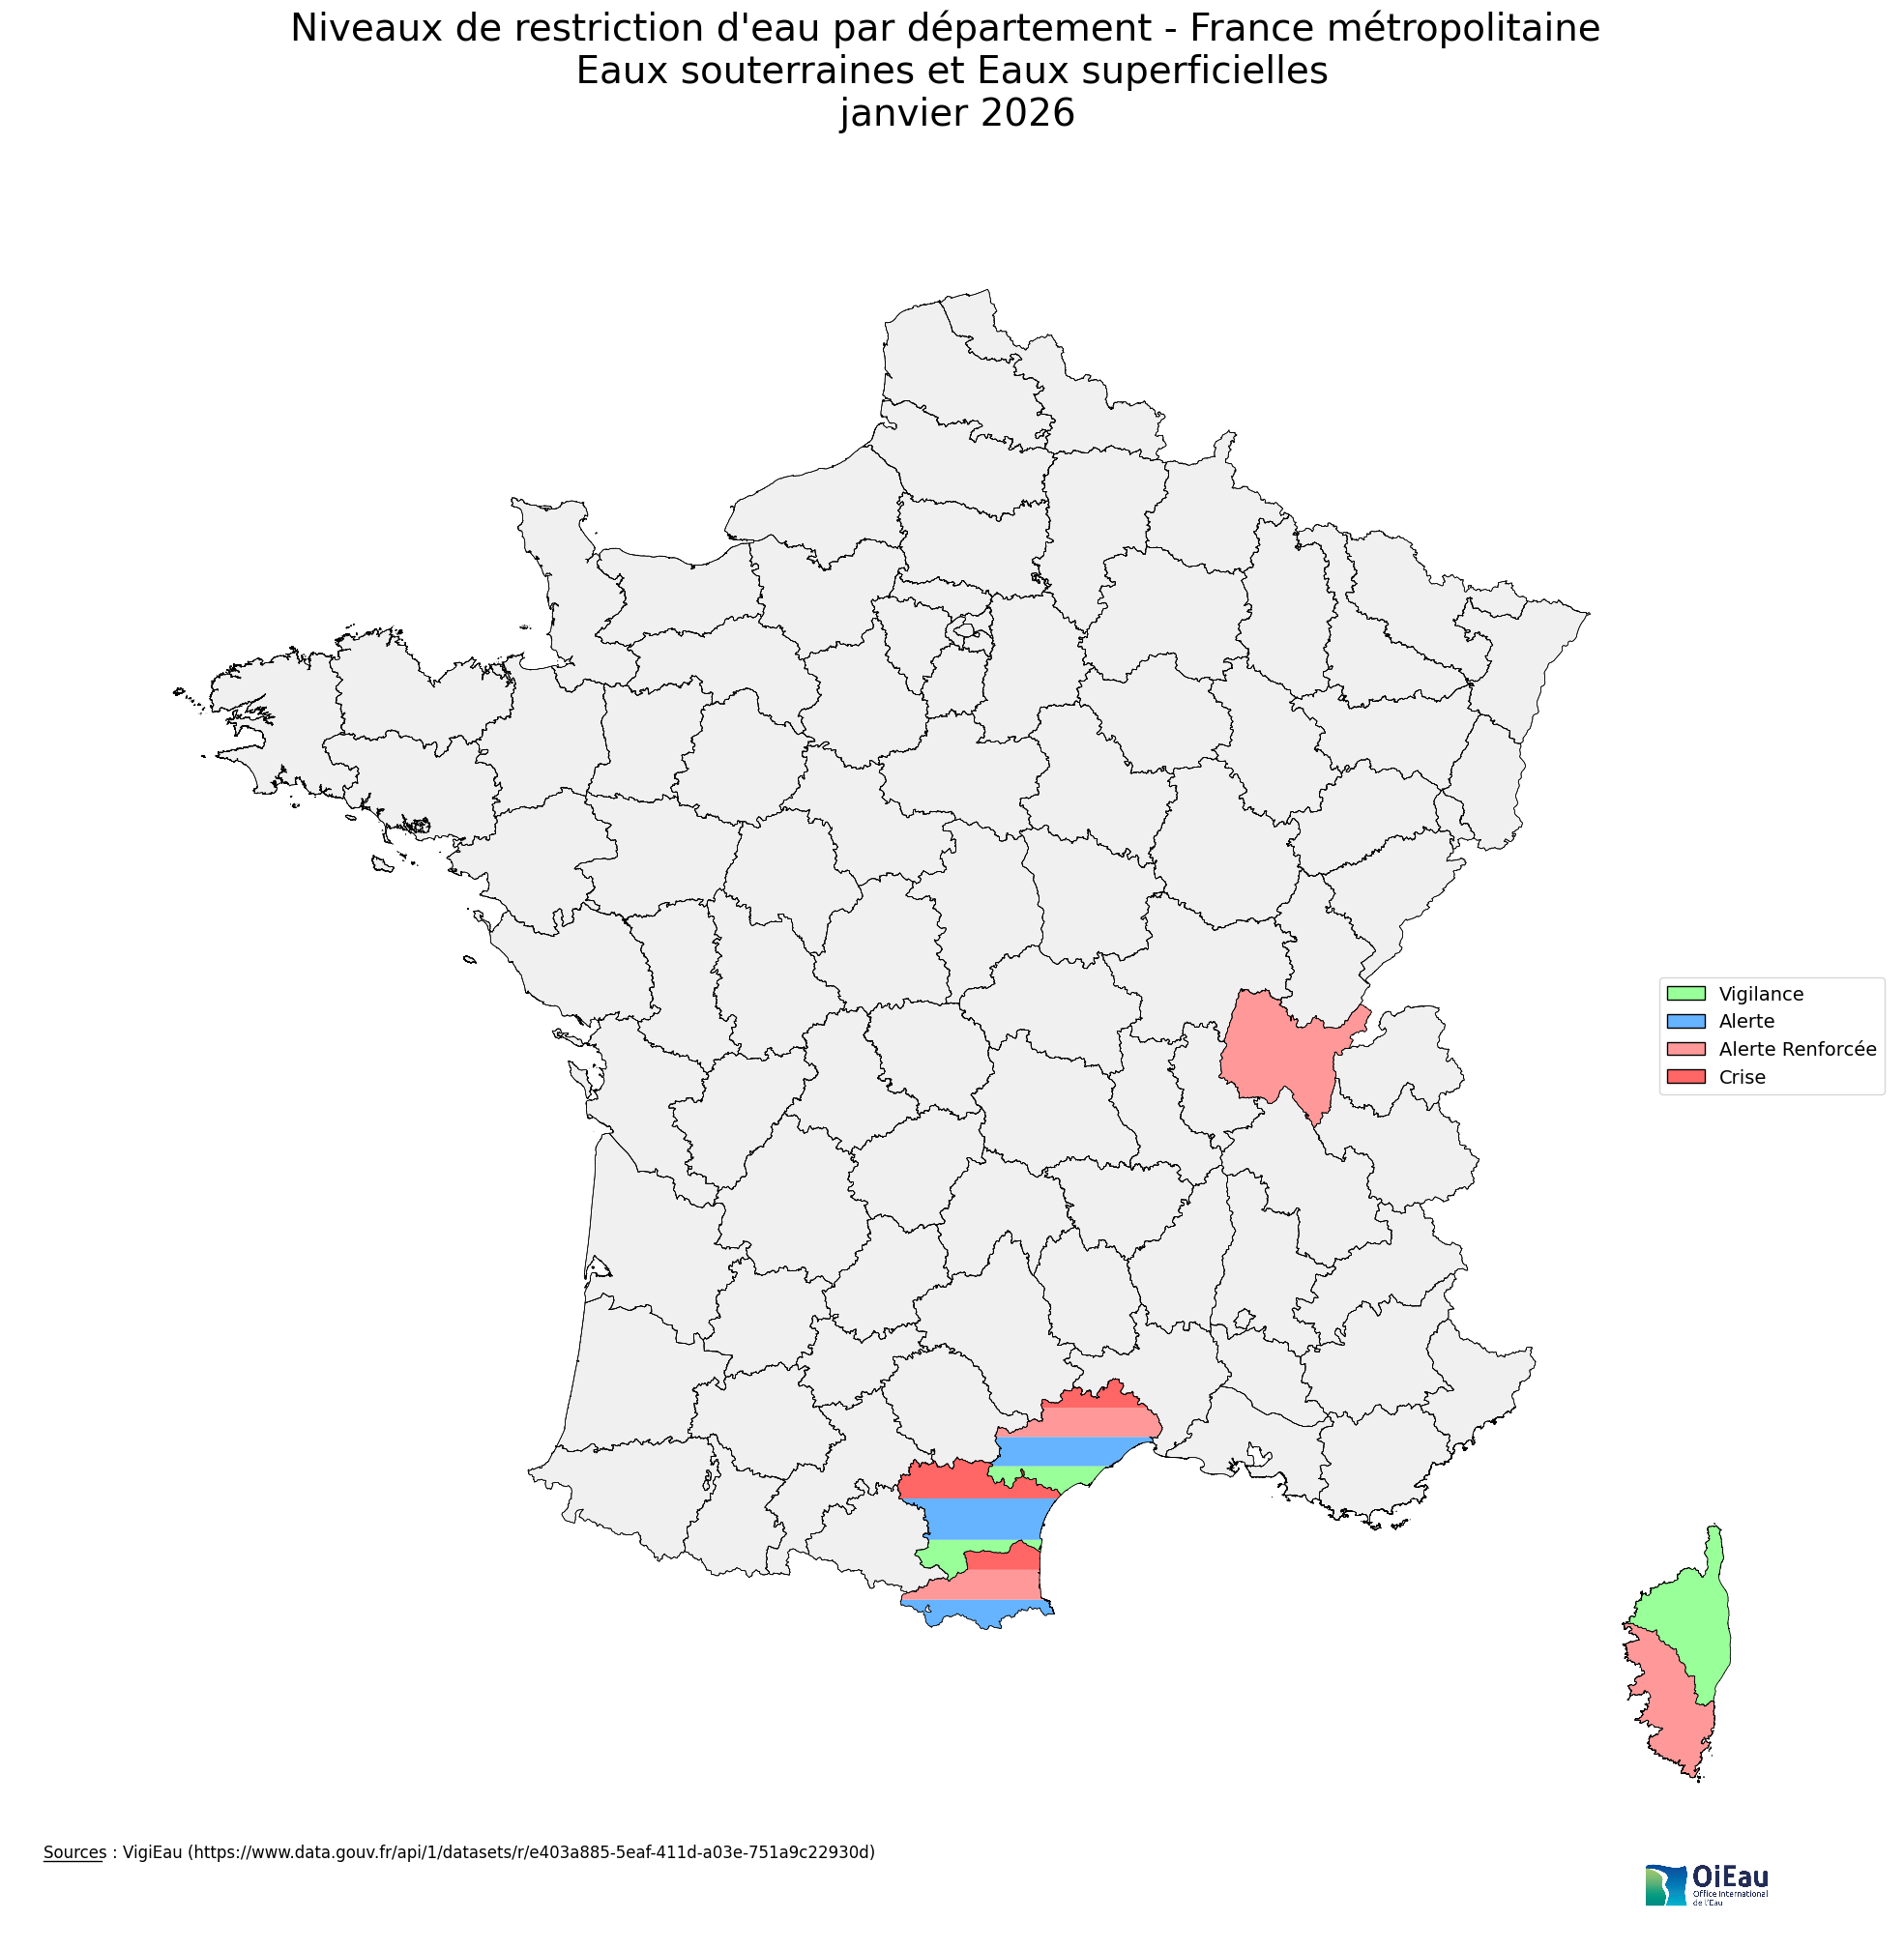

In [121]:
global_carte(mois=1, annee=2026, dossier_stockage=STORAGE_DIR)